In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import PolynomialFeatures

from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings('ignore')

# Re-load the dataset
df_new = pd.read_csv('../data/transform/transformed_data.csv')

In [2]:
cr = ['Unnamed: 0', 'match_api_id', 'season', 'stage', 'Unnamed: 0']
df_numerical = df_new.drop(cr, axis=1)
df_numerical.to_csv('../data/transform/df_numerical.csv')
df_numerical.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3040 entries, 0 to 3039
Data columns (total 53 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   date                          3040 non-null   object 
 1   away_team                     3040 non-null   int64  
 2   home_team                     3040 non-null   int64  
 3   home_team_goal                3040 non-null   int64  
 4   away_team_goal                3040 non-null   int64  
 5   result_match                  3040 non-null   int64  
 6   away_shoton                   3040 non-null   int64  
 7   home_possession               3040 non-null   int64  
 8   home_shoton                   3040 non-null   int64  
 9   away_possession               3040 non-null   int64  
 10  player_rating_home_player_1   3040 non-null   int64  
 11  player_rating_home_player_2   3040 non-null   int64  
 12  player_rating_home_player_3   3040 non-null   int64  
 13  pla

In [3]:
def remove_highly_correlated_features(df, threshold=0.9, cols_to_remove=['date', 'away_team', 'home_team','home_team_goal',]):
    """
    Removes features from the dataframe that have a correlation coefficient
    higher than the specified threshold.

    Parameters:
    df (pd.DataFrame): Dataframe with numerical features.
    threshold (float): Threshold for high correlation.

    Returns:
    tuple: (set of features to remove, reduced dataframe shape)
    """
    # Calculate the correlation matrix
    correlation_matrix = df.drop(cols_to_remove, axis=1).corr()

    # Find feature pairs with correlation greater than the threshold
    # Interested in absolute value of correlation coefficient
    highly_correlated_pairs = correlation_matrix.abs().unstack().sort_values(ascending=False)
    highly_correlated_pairs = highly_correlated_pairs[highly_correlated_pairs >= threshold]
    highly_correlated_pairs = highly_correlated_pairs[highly_correlated_pairs < 1]  # Remove self-correlation

    # Since correlation is symmetric, we'll take one of each pair
    # We will only take the first of the pair to remove.
    features_to_remove = set([pair[0] for pair in highly_correlated_pairs.index])

    print(features_to_remove)
    df_ = df.drop(columns=features_to_remove)
    print(df_.shape)
    
    return df_

data_reduced = remove_highly_correlated_features(df_numerical)

{'player_rating_away_player_2', 'player_rating_away_player_5', 'player_rating_home_player_6', 'points_home', 'away_wins', 'player_rating_home_player_1', 'player_rating_home_player_5', 'player_rating_away_player_3', 'away_team_strength', 'home_wins', 'player_rating_away_player_1', 'points_away', 'player_rating_home_player_3', 'player_rating_away_player_4', 'player_rating_home_player_2', 'player_rating_away_player_6', 'home_team_strength', 'player_rating_home_player_4'}
(3040, 35)


In [4]:
# Splitting the original dataset
X = data_reduced.drop(['result_match', 'date', 'away_team', 'away_team_goal', 'home_team','home_team_goal', 'away_possession', 'home_shoton', 'home_possession', 'away_shoton', ], axis=1)
y = data_reduced['result_match']
X_train_full, X_test_full, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the XGBClassifier
xgb_full = XGBClassifier(random_state=42)

# Train the model on the full feature set
xgb_full.fit(X_train_full, y_train)

# Predictions and evaluation on the full feature set
y_pred_full = xgb_full.predict(X_test_full)
accuracy_full = accuracy_score(y_test, y_pred_full)

accuracy_full

0.5

In [5]:
# Feature engineering: Aggregated player ratings for home and away teams
player_rating_columns_home = [col for col in df_new.columns if 'home_player' in col]
player_rating_columns_away = [col for col in df_new.columns if 'away_player' in col]

# data_cleaned['avg_player_rating_home'] = data_cleaned[player_rating_columns_home].mean(axis=1)
# data_cleaned['avg_player_rating_away'] = data_cleaned[player_rating_columns_away].mean(axis=1)

In [6]:
data_reduced['avg_player_rating_home'] = data_reduced[['player_rating_home_player_7','player_rating_home_player_8','player_rating_home_player_9',
              'player_rating_home_player_10', 'player_rating_home_player_11']].mean(axis=1)

data_reduced['avg_player_rating_away'] = data_reduced[['player_rating_away_player_7','player_rating_away_player_8','player_rating_away_player_9',
              'player_rating_away_player_10', 'player_rating_away_player_11']].mean(axis=1)

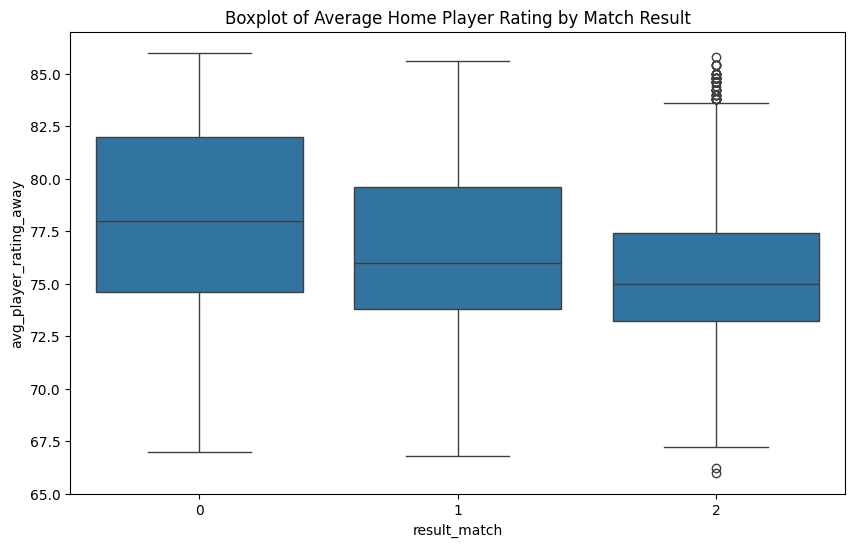

In [7]:
# Boxplot for 'avg_player_rating_home' vs 'result_match'
plt.figure(figsize=(10, 6))
sns.boxplot(x='result_match', y='avg_player_rating_away', data=data_reduced)
plt.title('Boxplot of Average Home Player Rating by Match Result')
plt.show()

In [8]:
# Clear negative correaltion between result_match and avg_palyer_rating_away

In [9]:
# List of player positions for which we have ratings
player_positions = range(7, 12)

# Calculate the difference from the average for each player
for position in player_positions:
    home_player_col = f'player_rating_home_player_{position}'
    away_player_col = f'player_rating_away_player_{position}'
    
    # Create new features for home and away players
    data_reduced[f'diff_player_{position}'] = data_reduced[home_player_col] - data_reduced[away_player_col]
    # data_reduced.drop([home_player_col, away_player_col], axis=1, inplace=True)

# Display the dataframe to confirm the new features
data_reduced.filter(like='diff_player').columns

Index(['diff_player_7', 'diff_player_8', 'diff_player_9', 'diff_player_10',
       'diff_player_11'],
      dtype='object')

In [ ]:
# Creating new features based on the interactions
data_reduced['new_feature_3'] = data_reduced['diff_player_9'] + data_reduced['points_diff']
data_reduced['new_feature_4'] = data_reduced['avg_player_rating_home'] + data_reduced['points_diff']
data_reduced['new_feature_5'] = data_reduced['diff_player_8'] * data_reduced['diff_player_9'] * data_reduced['points_diff']

In [ ]:
def calculate_rolling_averages(rolling_window_size, df, stat_columns):
    """
    Calculate rolling averages for various statistics without including the current match.

    Args:
    - rolling_window_size (int): Number of previous matches to include in the rolling average.
    - df (pd.DataFrame): The DataFrame containing the match data.
    - stat_columns (dict): A dictionary with keys for each stat category (e.g., 'goals', 'possession', 'shots_on'),
                           and values being another dictionary with 'home' and 'away' keys mapping to the respective columns.

    Returns:
    - pd.DataFrame: The DataFrame with new rolling average columns added.
    """

    # Iterate through each stat category
    for stat, columns in stat_columns.items():
        # Define new feature names for rolling features
        home_feature_name = f'home_{stat}_rolling'
        away_feature_name = f'away_{stat}_rolling'

        # Calculate rolling averages for home and away statistics
        for team_type in ['home', 'away']:
            # Sort by team and date
            df.sort_values(by=[f'{team_type}_team', 'date'], ascending=True, inplace=True)
            
            # Calculate rolling averages for the given stat
            df[home_feature_name if team_type == 'home' else away_feature_name] = (
                df.groupby(f'{team_type}_team')[columns[team_type]]
                .apply(lambda x: x.shift().rolling(window=rolling_window_size).mean())
                .reset_index(level=0, drop=True)
            )
            
            # Calculate the means for rolling features
            rolling_means = df.groupby(f'{team_type}_team')[home_feature_name if team_type == 'home' else away_feature_name].transform('mean')
            
            # Fill NaN values in rolling features with the team-specific means
            df[home_feature_name if team_type == 'home' else away_feature_name] = (
                df[home_feature_name if team_type == 'home' else away_feature_name].fillna(rolling_means)
            )

    return df

In [ ]:
# Define a range of window sizes to test
window_sizes = [2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 15]

# Define your statistical categories and their corresponding columns
stat_columns = {
    'goals': {
        'home': 'home_team_goal',
        'away': 'away_team_goal'
    },
    'possession': {
        'home': 'home_possession',
        'away': 'away_possession'
    },
    'shots_on': {
        'home': 'home_shoton',
        'away': 'away_shoton'
    }
}

# Placeholder for best score and corresponding window size
best_score = -float('inf')
best_window_size = None

# Iterate over window sizes to find the best one
for window_size in window_sizes:
    # Calculate rolling averages using the current window size
    df_with_rolling = calculate_rolling_averages(window_size, data_reduced.copy(), stat_columns)

    df_with_rolling = df_with_rolling.drop(['date', 'away_team', 'away_team_goal', 'home_team','home_team_goal', 'away_possession', 'home_shoton', 'home_possession', 'away_shoton'], axis=1)
    
    # Extract features and target for model training
    X = df_with_rolling.drop(['result_match'], axis=1)
    y = df_with_rolling['result_match']
    
    # Define your model
    model = XGBClassifier(random_state=42)  # Use your actual model here
    
    # Perform cross-validation
    scores = cross_val_score(model, X, y, cv=2, scoring='accuracy')  # Change scoring method as needed
    
    # Calculate the mean score
    mean_score = scores.mean()
    
    # Update best score and window size if current score is better
    if mean_score > best_score:
        best_score = mean_score
        best_window_size = window_size

# best_window_size now holds the size of the window that gave the best performance
print(f"Best window size: {best_window_size} with score: {best_score}")

In [ ]:
df_with_rolling = calculate_rolling_averages(best_window_size, df=data_reduced.copy(), stat_columns=stat_columns)
df_with_rolling = df_with_rolling.drop(['date', 'away_team', 'away_team_goal', 'home_team','home_team_goal', 'away_possession', 'home_shoton', 'home_possession', 'away_shoton'], axis=1)

In [ ]:
# Splitting the original dataset
X = df_with_rolling.drop('result_match', axis=1)
y = df_with_rolling['result_match']
X_train_full, X_test_full, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the XGBClassifier
xgb_full = XGBClassifier(random_state=42)

# Train the model on the full feature set
xgb_full.fit(X_train_full, y_train)

# Predictions and evaluation on the full feature set
y_pred_full = xgb_full.predict(X_test_full)
accuracy_full = accuracy_score(y_test, y_pred_full)

accuracy_full

In [ ]:
df_with_rolling.shape

In [ ]:
df = df_with_rolling.copy()

In [ ]:
# Assuming 'df' is your original DataFrame

# Creating difference features
df['goal_difference_rolling'] = df['home_goals_rolling'] - df['away_goals_rolling']
df['possession_difference_rolling'] = df['home_possession_rolling'] - df['away_possession_rolling']
df['shots_on_target_difference_rolling'] = df['home_shots_on_rolling'] - df['away_shots_on_rolling']

# Creating ratio features (adding 1 to the denominator to avoid division by zero)
df['goals_ratio_rolling'] = df['home_goals_rolling'] / (df['away_goals_rolling'] + 1)
df['possession_ratio_rolling'] = df['home_possession_rolling'] / (df['away_possession_rolling'] + 1)
df['shots_on_target_ratio_rolling'] = df['home_shots_on_rolling'] / (df['away_shots_on_rolling'] + 1)

df.drop(['home_goals_rolling', 'away_goals_rolling', 'home_possession_rolling', 'away_possession_rolling', 
         'home_shots_on_rolling', 'away_shots_on_rolling'], axis=1, inplace=True)


# Checking the correlation of the new features with the target variable
correlations = df[['goal_difference_rolling', 'possession_difference_rolling', 'shots_on_target_difference_rolling',
                   'goals_ratio_rolling', 'possession_ratio_rolling', 'shots_on_target_ratio_rolling',
                   'result_match']].corr()

# Create a heatmap for the selected features
plt.figure(figsize=(10, 8))
sns.heatmap(correlations, annot=True, fmt=".2f", cmap='viridis')
plt.title('Heatmap of Selected Feature Correlations')
plt.show()

In [ ]:
# Splitting the original dataset
X = df.drop('result_match', axis=1)
y = df['result_match']
X_train_full, X_test_full, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

from sklearn.model_selection import cross_val_score

# Initialize the XGBClassifier
xgb_full = XGBClassifier(random_state=42)

# Cross-validation
cv_scores = cross_val_score(xgb_full, X_train_full, y_train, cv=10, scoring='f1_weighted')

# Print the cross-validation scores
print("Cross-validation scores: ", cv_scores)

# Print the average cross-validation score
print("Average cross-validation score: ", cv_scores.mean())

In [ ]:
# Positive correlations are shown by bars extending above the horizontal line (y=0), 
# indicating that an increase in these features is associated with higher values of 'result_match'.

# Negative correlations, shown by bars below the line, 
# suggest that an increase in these features is associated with lower values of 'result_match'.

In [ ]:
# Calculate the Pearson correlation matrix
correlation_matrix = df.corr()

# Extract the correlations with the target variable 'result_match'
correlations_with_target = correlation_matrix['result_match'].sort_values(ascending=False)

correlations_with_target

# Select the top 5 positively correlated and top 5 negatively correlated features (excluding the target itself)
top_positive_correlated_features = correlations_with_target.index[1:6].tolist()
top_negative_correlated_features = correlations_with_target.index[-5:].tolist()
selected_features = top_positive_correlated_features + top_negative_correlated_features

# Create a new dataframe with the selected features and the target variable
selected_data = df[selected_features + ['result_match']]

# Create a heatmap for the selected features
plt.figure(figsize=(10, 8))
sns.heatmap(selected_data.corr(), annot=True, fmt=".2f", cmap='viridis')
plt.title('Heatmap of Selected Feature Correlations')
plt.show()

In [ ]:
df.shape

In [ ]:
df_ = df.copy()

In [ ]:
# 'avg_possession_home', 'combined_3_alt', 'new_feature_4', 
# 'combined_1', 'diff_player_10', 'diff_player_7'
# 'avg_player_rating_away', 'combined_3_alt', 'new_feature_4'
# 'combined_2','goals_ratio_rolling', 'new_feature_4'
# 'avg_player_rating_away', 'avg_player_rating_home', 'combined_3_alt'


# 'combined_3_alt', 'new_feature_4'
# 'combined_1', 'combined_3_alt'
# 'combined_1', 'diff_player_10'
# 'combined_2', 'new_feature_4'
# 'combined_1', 'new_feature_4'
# 'new_feature_4', 'new_feature_5'
# 'combined_1', 'diff_player_7'
# 'avg_possession_home', 'diff_player_11'
# 'diff_player_10', 'diff_player_7'
# 'avg_possession_home', 'combined_3_alt'
# 'avg_possession_home', 'diff_player_8'

In [ ]:
df_['ratio_away_rating_player_7_8_9_10_11'] = df_['player_rating_away_player_7'] * df_['player_rating_away_player_8'] * df_['player_rating_away_player_9'] * df_['player_rating_away_player_10'] * df_['player_rating_away_player_11']
df_['ratio_home_rating_player_7_8_9_10_11'] = df_['player_rating_away_player_7'] * df_['player_rating_away_player_8'] * df_['player_rating_away_player_9'] * df_['player_rating_home_player_10'] * df_['player_rating_home_player_11']

# diff_player_10|diff_player_7
# df_['combined_4'] = df_['diff_player_10'] * df_['diff_player_7']
# df_['combined_4_alt'] = df_['diff_player_10'] + df_['diff_player_7']

# Combination 1: new_feature_3 and new_feature_4
df_['combined_1'] = df_['new_feature_3'] * df_['new_feature_4']

# Combination 2: new_feature_4, new_feature_5, and avg_player_rating_away
df_['combined_2'] = df_['new_feature_4'] * df_['new_feature_5'] * df_['avg_player_rating_away']

# Combination 3: new_feature_3 with avg_player_rating_away
df_['combined_3_alt'] = df_['new_feature_3'] * df_['avg_player_rating_away']

In [ ]:
# 'new_feature_3', 'avg_player_rating_away', 'new_feature_5', 'new_feature_4', 'avg_player_rating_away', 'new_feature_3',
df_.drop([
        'player_rating_away_player_7', 'player_rating_away_player_8', 'player_rating_away_player_9', 'player_rating_away_player_10', 'player_rating_away_player_11',
         'player_rating_home_player_7', 'player_rating_home_player_8', 'player_rating_home_player_9', 'player_rating_home_player_10', 'player_rating_home_player_11'], axis=1, inplace=True)

In [ ]:
# Creating new features based on the pairwise interactions
df_['new_feature_7'] = df_['combined_3_alt'] + df_['combined_2']  # Sum of combined_3_alt and combined_2
df_['new_feature_8'] = df_['combined_2'] * df_['combined_1']      # Product of combined_2 and combined_1
df_['new_feature_9'] = df_['combined_1'] / (df_['ratio_home_rating_player_7_8_9_10_11'] + 1)  # Ratio

# Creating new features based on the three-feature interactions
df_['new_feature_44'] = df_['combined_3_alt'] * df_['combined_2'] * df_['shots_on_target_difference_rolling']  # Product
df_['new_feature_55'] = df_['combined_2'] + df_['home_avg_goals_conceded'] + df_['home_sum_points']  # Sum
df_['new_feature_99'] = (df_['avg_player_rating_away'] * df_['combined_3_alt']) / (df_['away_avg_goals_conceded'] + 1)  # Complex Ratio

# Display the first few rows with the new features
df_[['new_feature_7', 'new_feature_8', 'new_feature_9', 'new_feature_44', 'new_feature_55', 'new_feature_99']].head()

In [69]:
df_['ratio_away_rating_player_7_8_9_10_11'] = df_['player_rating_away_player_7'] * df_['player_rating_away_player_8'] * df_['player_rating_away_player_9'] * df_['player_rating_away_player_10'] * df_['player_rating_away_player_11']
df_['ratio_home_rating_player_7_8_9_10_11'] = df_['player_rating_away_player_7'] * df_['player_rating_away_player_8'] * df_['player_rating_away_player_9'] * df_['player_rating_home_player_10'] * df_['player_rating_home_player_11']

# diff_player_10|diff_player_7
# df_['combined_4'] = df_['diff_player_10'] * df_['diff_player_7']
# df_['combined_4_alt'] = df_['diff_player_10'] + df_['diff_player_7']

# Combination 1: new_feature_3 and new_feature_4
df_['combined_1'] = df_['new_feature_3'] * df_['new_feature_4']

# Combination 2: new_feature_4, new_feature_5, and avg_player_rating_away
df_['combined_2'] = df_['new_feature_4'] * df_['new_feature_5'] * df_['avg_player_rating_away']

# Combination 3: new_feature_3 with avg_player_rating_away
df_['combined_3_alt'] = df_['new_feature_3'] * df_['avg_player_rating_away']

In [70]:
# 'new_feature_3', 'avg_player_rating_away', 'new_feature_5', 'new_feature_4', 'avg_player_rating_away', 'new_feature_3',
df_.drop([
        'player_rating_away_player_7', 'player_rating_away_player_8', 'player_rating_away_player_9', 'player_rating_away_player_10', 'player_rating_away_player_11',
         'player_rating_home_player_7', 'player_rating_home_player_8', 'player_rating_home_player_9', 'player_rating_home_player_10', 'player_rating_home_player_11'], axis=1, inplace=True)

In [73]:
# Creating new features based on the pairwise interactions
df_['new_feature_7'] = df_['combined_3_alt'] + df_['combined_2']  # Sum of combined_3_alt and combined_2
df_['new_feature_8'] = df_['combined_2'] * df_['combined_1']      # Product of combined_2 and combined_1
df_['new_feature_9'] = df_['combined_1'] / (df_['ratio_home_rating_player_7_8_9_10_11'] + 1)  # Ratio

# Creating new features based on the three-feature interactions
df_['new_feature_44'] = df_['combined_3_alt'] * df_['combined_2'] * df_['shots_on_target_difference_rolling']  # Product
df_['new_feature_55'] = df_['combined_2'] + df_['home_avg_goals_conceded'] + df_['home_sum_points']  # Sum
df_['new_feature_99'] = (df_['avg_player_rating_away'] * df_['combined_3_alt']) / (df_['away_avg_goals_conceded'] + 1)  # Complex Ratio

# Display the first few rows with the new features
df_[['new_feature_7', 'new_feature_8', 'new_feature_9', 'new_feature_44', 'new_feature_55', 'new_feature_99']].head()

,new_feature_7,new_feature_8,new_feature_9,new_feature_44,new_feature_55,new_feature_99
386,3293383.80,6.138910e+09,1.399434e-06,-9.855883e+09,3292010.70,92031.240000
412,80678908.80,3.366621e+11,2.076151e-06,7.921314e+11,80676316.90,105459.736527
423,9445081.24,2.318312e+10,8.520230e-07,1.833048e+10,9443249.54,61173.777778
441,1353389.00,1.568301e+09,4.821485e-07,1.582229e+09,1352470.80,25380.868914
464,-32412.96,-0.000000e+00,0.000000e+00,-0.000000e+00,-32400.26,0.000000


In [74]:
df_.shape

(3040, 43)

In [75]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

X = df_.drop('result_match', axis=1)
y = df_['result_match']
X_train_full, X_test_full, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [76]:
from sklearn.model_selection import cross_val_score

# Initialize the XGBClassifier
xgb_full = XGBClassifier(random_state=42)

# Cross-validation
cv_scores = cross_val_score(xgb_full, X_train_full, y_train, cv=10, scoring='f1_weighted')

# Print the cross-validation scores
print("Cross-validation scores: ", cv_scores)

# Print the average cross-validation score
print("Average cross-validation score: ", cv_scores.mean())

Cross-validation scores:  [0.4125813  0.41277387 0.44715174 0.44373909 0.4725713  0.42002511
 0.43976812 0.49176709 0.45580829 0.46263641]
Average cross-validation score:  0.445882233280003


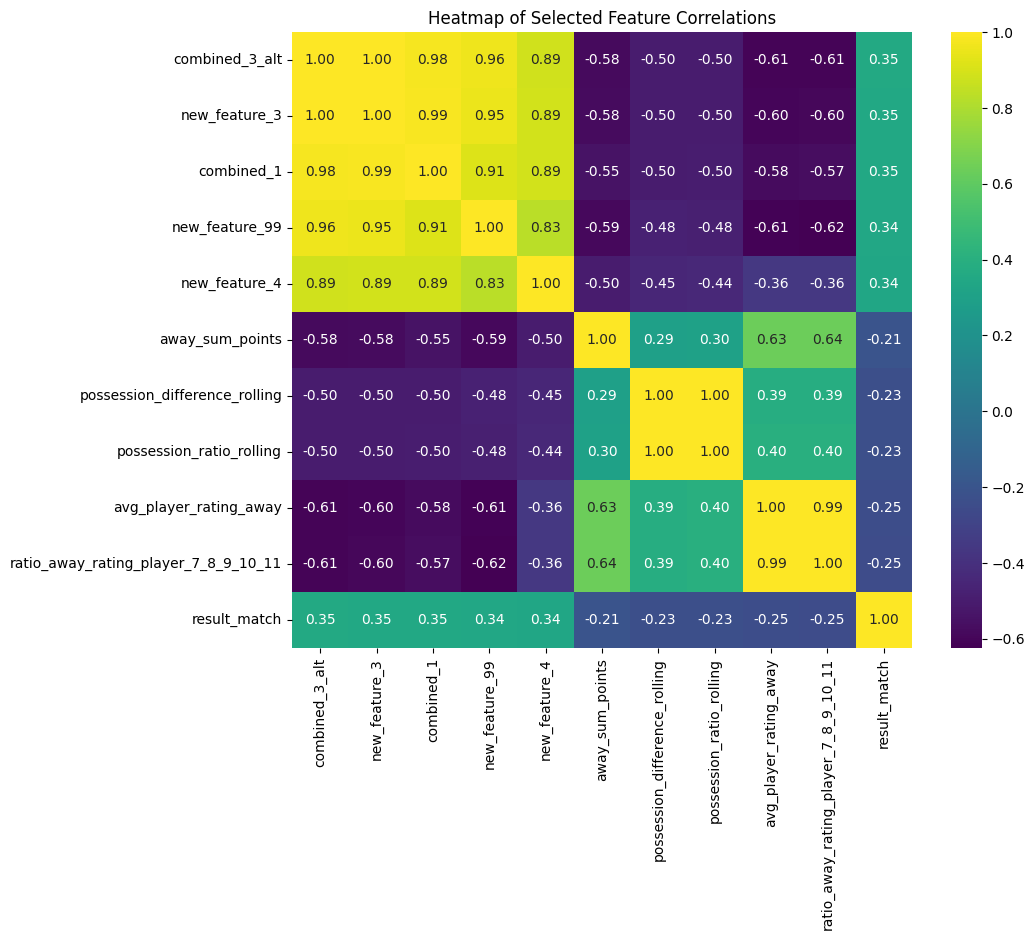

In [77]:
# Calculate the Pearson correlation matrix
X_train_full['result_match'] = y_train

correlation_matrix = X_train_full.corr()

# Extract the correlations with the target variable 'result_match'
correlations_with_target = correlation_matrix['result_match'].sort_values(ascending=False)

correlations_with_target

# Select the top 5 positively correlated and top 5 negatively correlated features (excluding the target itself)
top_positive_correlated_features = correlations_with_target.index[1:6].tolist()
top_negative_correlated_features = correlations_with_target.index[-5:].tolist()
selected_features = top_positive_correlated_features + top_negative_correlated_features

# Create a new dataframe with the selected features and the target variable
selected_data = X_train_full[selected_features + ['result_match']]

# Create a heatmap for the selected features
plt.figure(figsize=(10, 8))
sns.heatmap(selected_data.corr(), annot=True, fmt=".2f", cmap='viridis')
plt.title('Heatmap of Selected Feature Correlations')
plt.show()

In [62]:
df_.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3040 entries, 386 to 3016
Data columns (total 37 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   result_match                          3040 non-null   int64  
 1   home_avg_goals_scored                 3040 non-null   float64
 2   away_avg_goals_scored                 3040 non-null   float64
 3   home_avg_goals_conceded               3040 non-null   float64
 4   away_avg_goals_conceded               3040 non-null   float64
 5   home_streak_wins                      3040 non-null   int64  
 6   away_streak_wins                      3040 non-null   int64  
 7   home_sum_points                       3040 non-null   int64  
 8   away_sum_points                       3040 non-null   int64  
 9   points_diff                           3040 non-null   int64  
 10  win_eachother_home                    3040 non-null   int64  
 11  win_eachother_away  

In [63]:
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA, KernelPCA

preprocessor = Pipeline(
    [
        ("scaler", MinMaxScaler()),
        ("pca", KernelPCA(n_components=2, random_state=42)),
    ]
)

clusterer = Pipeline(
   [
       (
           "kmeans",
           KMeans(
               n_clusters=3,
               init="k-means++",
               n_init=50,
               max_iter=500,
               random_state=42,
           ),
       ),
   ]
)

pipe = Pipeline(
    [
        ("preprocessor", preprocessor),
        ("clusterer", clusterer)
    ]
)

In [64]:
pipe.fit(X_train_full)

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('scaler', MinMaxScaler()),
                                 ('pca',
                                  KernelPCA(n_components=2,
                                            random_state=42))])),
                ('clusterer',
                 Pipeline(steps=[('kmeans',
                                  KMeans(max_iter=500, n_clusters=3, n_init=50,
                                         random_state=42))]))])

In [65]:
X_train_full.shape

(2736, 37)

In [66]:
import os

output_dir = "../data/transform/"
filename= "df_engineered.csv"

full_path = os.path.join(output_dir, filename)
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

df_.to_csv(full_path)